# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка данных" data-toc-modified-id="Подготовка данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Подготовка данных

In [46]:
# Блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Примечание: Ни разу до этого не использовал Ridge и Lasso, но мне показалось, что их особенности хорошо подойдут к данной задаче
# Если я верно понял, они помогают избирательно подходить к признакам, особенно если они коррелируют друг с другом,
# что в наших данных будет актуально
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Вспомогательное
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Дополнительное
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

# Оценки
from sklearn.metrics import mean_squared_error as mse, make_scorer

In [2]:
# Вспомогательные константы
RANDOM_STATE = 12345
#DATASET = 'https://code.s3.yandex.net/datasets/taxi.csv'

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
# Проверим, что индекс монотонный
df.index.is_monotonic

True

In [8]:
# Выполним ресемплирование по одному часу
df_resampled = df.resample('1H').sum()
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Вывод по подготовке данных
Данные были успешно загружены, индексы заменены на время, произведен ресемплинг по 1 часу.

# Анализ данных

In [9]:
# Посмотрим границы наших данных
df_resampled.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [10]:
df_resampled.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

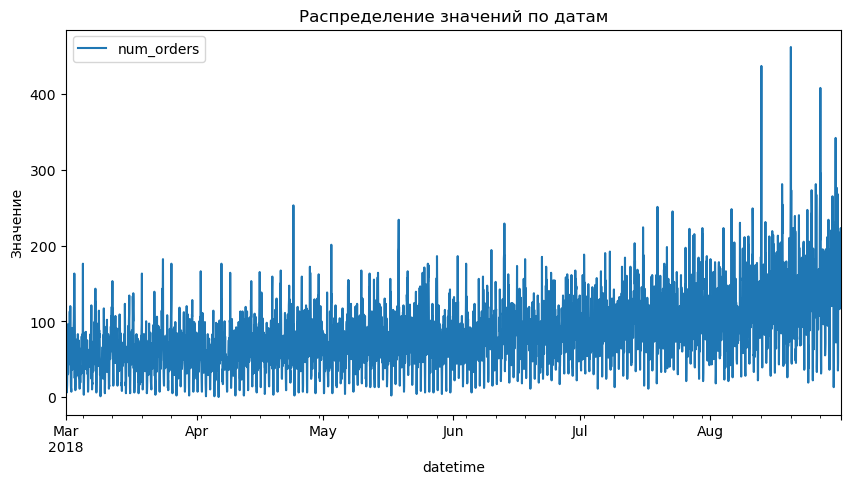

In [11]:
# Посмотрим график
def draw(data):
    fig, ax = plt.subplots(1)
    ax.set_title('Распределение значений по датам')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Значение')
    data.plot(figsize=(10,5), ax=ax)
    
draw(df_resampled)

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> У меня огромная диагональ и влезает два целых графика, но я поправил :)
</div> 

<br/>    

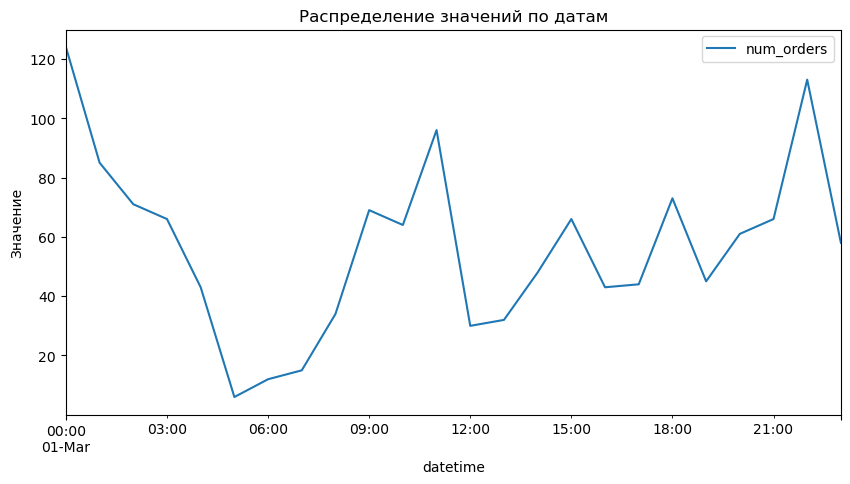

In [12]:
# Попробуем меньшие размерности, посмотрим день
draw(df_resampled.head(24))

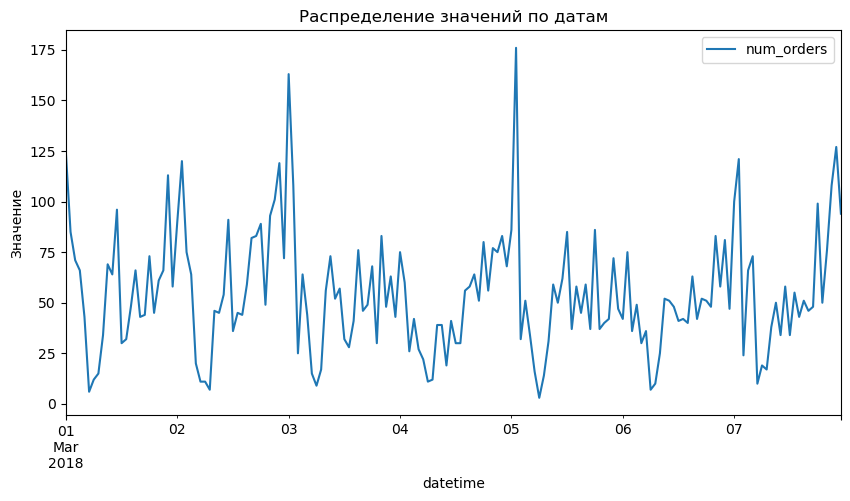

In [13]:
# Неделя
draw(df_resampled.head(24 * 7))

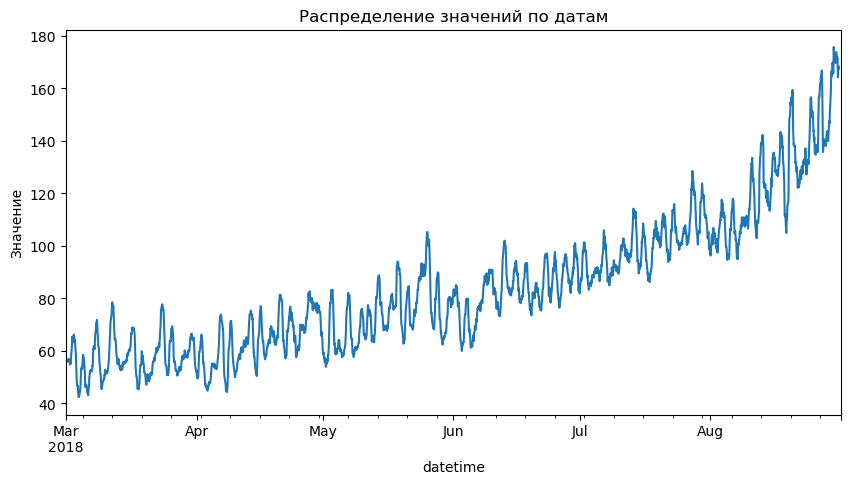

In [14]:
# Разложение временного ряда на тренд, сезонность и остаток
df_resampled_decomposed = seasonal_decompose(df_resampled)
# Тренд
draw(df_resampled_decomposed.trend)

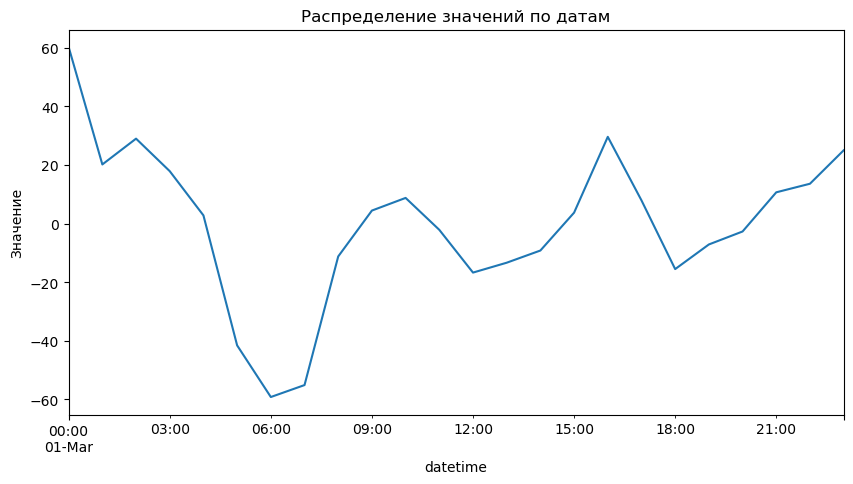

In [15]:
# Сезонность (день)
draw(df_resampled_decomposed.seasonal.head(24))

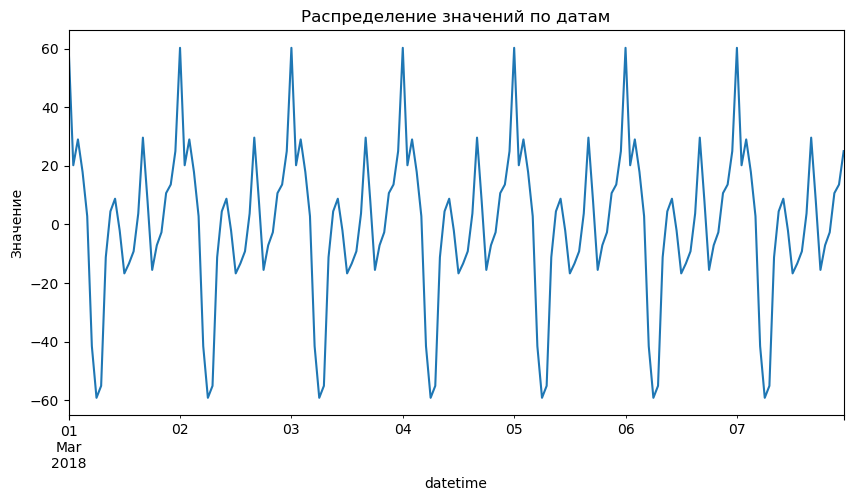

In [16]:
# Сезонность (неделя)
draw(df_resampled_decomposed.seasonal.head(24*7))

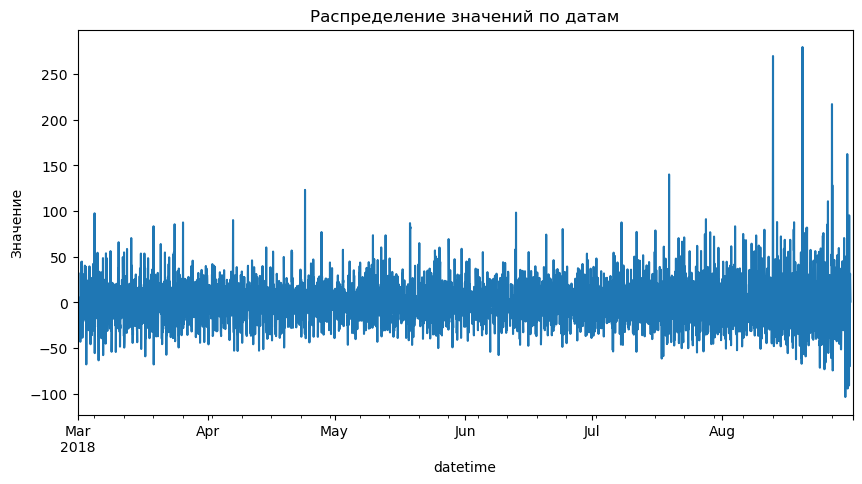

In [17]:
# Остаток
draw(df_resampled_decomposed.resid)

## Вывод по анализу данных

Наблюдается восходящий тренд и дневная сезонность. Летом наблюдается самое большое количество поездок на такси. Самым популярным временем является промужток с десяти вечера до часа ночи. Также отмечается рост количества заказов в утренний и вечерний час пики.

# Обучение моделей

In [18]:
def rmse(predicted, target):
    return mse(predicted, target,squared=False)

In [19]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [20]:
# Подготовим признаки
TARGET_NAME = 'num_orders'

def make_features(df, max_lag, rolling_mean_size, use_hour, use_day_of_week):
    data = df.copy()
    
    # Календарные признаки
    # data['day'] = data.index.day
    # data['dayofweek'] = data.index.dayofweek
    
    if use_hour:
        hour = data.index.hour
        data['hour'] = hour
        data['sin_hour'] = np.sin(2 * np.pi * hour / 24)
        data['cos_hour'] = np.cos(2 * np.pi * data.index.hour / 24)
        
    if use_day_of_week:
        day_of_week = data.index.dayofweek
        data['day_of_week'] = day_of_week
        data['sin_day_of_week'] = np.sin(2 * np.pi * day_of_week / 7)
        data['cos_day_of_week'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[TARGET_NAME].shift(lag)

    data['rolling_mean'] = data[TARGET_NAME].shift().rolling(rolling_mean_size).mean()
    
    return data

In [21]:
# Поскольку мы сами будем формировать признаки, есть смысл создать несколько наборов с различными параметрами
# Проверять все будем на линейной регрессии, таким образом мы отберем признаки, которые покажут себя лучше всего
# и уже на них будем проверять все остальные модели


features_search_result = []

for max_lag in range(10, 41, 10):
    for rolling_mean_size in (6, 19, 6):
        for use_hour in range(2):
            for use_day_of_week in range(2):
                features = make_features(df_resampled, max_lag, rolling_mean_size, bool(use_hour), bool(use_day_of_week))
                train, test = train_test_split(features, shuffle=False, test_size=0.1)
                valid, train = train_test_split(train, shuffle=False, test_size=0.6)
    
                train = train.dropna()
                valid = train.dropna()
                
                train_target = train[TARGET_NAME]
                train_features = train.drop(columns=[TARGET_NAME])
                target_valid = valid[TARGET_NAME]
                features_valid = valid.drop(columns=[TARGET_NAME])
                test_target = test[TARGET_NAME]
                test_features = test.drop(columns=[TARGET_NAME])
                
                model = LinearRegression()
                model.fit(train_features.dropna(), train_target.dropna())
                test_predicted = model.predict(test_features)
                
                tmp_result = dict()
                tmp_result['max_lag'] = max_lag
                tmp_result['rolling_mean_size'] = rolling_mean_size
                tmp_result['use_hour'] = use_hour
                tmp_result['use_day_of_week'] = use_day_of_week
                tmp_result['rmse'] = rmse(test_predicted, test_target)
                
                features_search_result.append(tmp_result)

In [22]:
# Найдем лучший вариант
min_rmse_row = dict();
min_rmse_row['rmse'] = 100;

for row in features_search_result:
    if (row['rmse'] < min_rmse_row['rmse']):
        min_row_rmse = row

# Посмотрим, что получилось:
min_row_rmse

{'max_lag': 40,
 'rolling_mean_size': 6,
 'use_hour': 1,
 'use_day_of_week': 1,
 'rmse': 43.85115012902761}

In [23]:
# Итого, DF, с которым будем работать:
features = make_features(df_resampled, min_row_rmse['max_lag'],  min_row_rmse['rolling_mean_size'], min_row_rmse['use_hour'], min_row_rmse['use_day_of_week'])
train, test = train_test_split(features, shuffle=False, test_size=0.1)
valid, train = train_test_split(train, shuffle=False, test_size=0.6)

train = train.dropna()
valid = train.dropna()

train_target = train[TARGET_NAME]
train_features = train.drop(columns=[TARGET_NAME])
target_valid = valid[TARGET_NAME]
features_valid = valid.drop(columns=[TARGET_NAME])
test_target = test[TARGET_NAME]
test_features = test.drop(columns=[TARGET_NAME])

In [24]:
# Взял класс для оценки времени обучения и прочих параметров из своего прошлого проекта
class Model_class:
    def __init__(self, name, model):
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
    
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [25]:
# Создадим переменную, где будут храниться результаты
results = []

In [26]:
def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(info[0], info[1], info[2], info[3]))

In [27]:
# Определим разбитие для всех методов
ts_cv = TimeSeriesSplit(n_splits=2)

## Случайный лес

In [28]:
parameters = {'n_estimators': range(10,101,20),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}

model = RandomForestRegressor(random_state=RANDOM_STATE)
grid = GridSearchCV(model, parameters, cv=ts_cv, scoring=rmse_scorer)
grid.fit(train_features, train_target)

grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 70}

In [29]:
# {'max_depth': 7,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 70}

In [30]:
# Проверим наш случайный лес
model_forest = RandomForestRegressor(max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=70, random_state=RANDOM_STATE)

model_forest_helper = Model_class('Random forest', model_forest)
model_forest_helper.fit(train_features, train_target)
model_forest_helper.predict(features_valid, target_valid)

results.append(model_forest_helper.getResult())

## Бустинг

### LGBMRegressor

In [50]:
%%time

gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=RANDOM_STATE, force_row_wise = True);
gbm_params = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 61, 20), 'num_leaves': range(20, 41, 10)};

grid_gbm = GridSearchCV(gbm, gbm_params, cv=ts_cv, scoring=rmse_scorer);
grid_gbm.fit(train_features, train_target);

grid_gbm.best_params_;

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 30}

In [32]:
# {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}

In [33]:
# Посмотрим, что получилось в итоге
model_gbm = grid_gbm.best_estimator_

model_gbm_helper = Model_class('LightGBM', model_gbm)
model_gbm_helper.fit(train_features, train_target)
model_gbm_helper.predict(features_valid, target_valid)

results.append(model_gbm_helper.getResult())

### CatBoost

In [34]:
%%time

cbr = CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=RANDOM_STATE)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=ts_cv, scoring=rmse_scorer)
grid_cbr.fit(train_features, train_target);

grid_cbr.best_params_

# Для отладки {'depth': 5, 'iterations': 40, 'learning_rate': 0.1778279410038923}

CPU times: total: 1min 38s
Wall time: 42.2 s


{'depth': 7, 'iterations': 40, 'learning_rate': 0.1778279410038923}

In [35]:
# Посмотрим, что получилось в итоге
model_cbr = grid_cbr.best_estimator_

model_cbr_helper = Model_class('CatBoost', model_cbr)
model_cbr_helper.fit(train_features, train_target)
model_cbr_helper.predict(features_valid, target_valid)

results.append(model_cbr_helper.getResult())

## Регрессии

### Линейная регрессия

In [36]:
# Попробуем линейную регрессию
model_lr = LinearRegression()

model_lr_helper = Model_class('Linear regression', model_lr)
model_lr_helper.fit(train_features, train_target)
model_lr_helper.predict(features_valid, target_valid)

results.append(model_lr_helper.getResult())

### Lasso

In [37]:
model_ridge = Ridge(random_state=RANDOM_STATE)

model_ridge_helper = Model_class('Ridge', model_ridge)
model_ridge_helper.fit(train_features, train_target)
model_ridge_helper.predict(features_valid, target_valid)

results.append(model_ridge_helper.getResult())

### Ridge

In [38]:
model_lasso = Lasso(random_state=RANDOM_STATE)

model_lasso_helper = Model_class('Lasso', model_lasso)
model_lasso_helper.fit(train_features, train_target)
model_lasso_helper.predict(features_valid, target_valid)

results.append(model_lasso_helper.getResult())

# Тестирование 

In [39]:
print_result(results)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           1.72539|           0.01599|    19.15450|
|            LightGBM|           0.07879|           0.00698|     9.18907|
|            CatBoost|           0.76493|           0.01397|    19.99265|
|   Linear regression|           0.01296|           0.00299|    26.45212|
|               Ridge|           0.00299|           0.00100|    26.45218|
|               Lasso|           0.00698|           0.00100|    27.14052|


Наилучший результат показала модель `LightGBM` c показателем целевой метрики RMSE в 9.18. Условий касательно времени заказчик не высказывал, поэтому смело можем остановиться на данной модели

In [40]:
# Вычислим предсказания для графика
model_gbm.fit(train_features, train_target)
test_predicted = model_gbm.predict(test_features)
rmse(test_predicted, test_target)

39.759146635065676

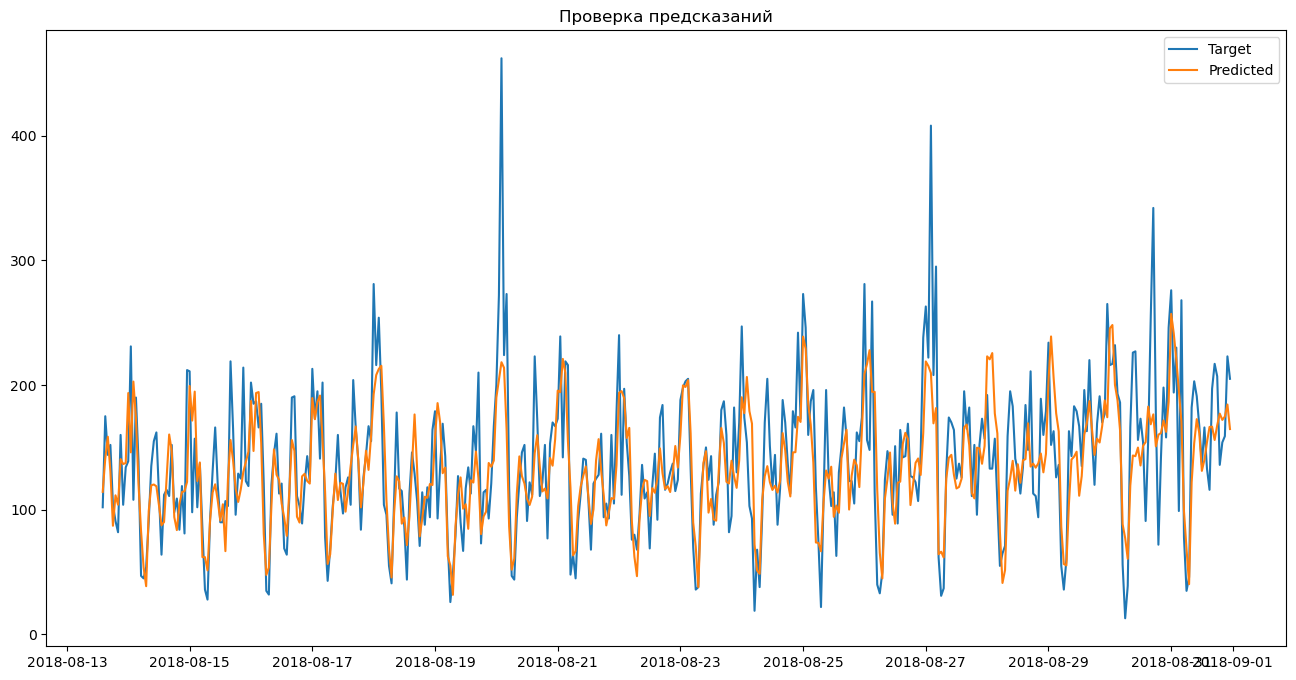

In [41]:
# Покажем предсказания в виде графика
plt.figure(figsize=(16, 8))
plt.plot(test_target, label='Target')
plt.plot(test_target.index, test_predicted, label='Predicted')
plt.title('Проверка предсказаний')
plt.legend()
plt.show()

# Вывод
- Мы изучили имеющиеся данные, определили тренд, сезонность и отклонения
- Выбрали и подготовили наиболее значимые признаки для обучения и работы наших моделей
- Разбили данные на три выборки, обучили и проверили модели. Выбрали модель `LightGBM` c показателем целевой метрики RMSE в 9.18.
- Предсказали значения на тестовой выборке, получив значение целевой метрике равное 39.76.